##### import statements

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
from datetime import datetime

##### read input csv file

In [3]:
df = pd.read_csv( "data/result/source_price.csv").drop( "Unnamed: 0", axis=1)

In [4]:
adj_close = df[ "Adj Close"].values

len_data = len( adj_close)

print( f"Date Length: { len_data}")

Date Length: 121


##### static variable

In [5]:
SPLIT = 0.85
SEQUENCE_LENGTH = 10
BATCH_SIZE = 100
INPUT_DIM = 1
INPUT_TIMESTEPS = 9
NEURONS = 50
EPOCHS = 5
PREDICTION_LENGTH = 1
DENSE_OUTPUT = 1
DROPOUT = 0.2

##### create window data

In [6]:
def create_win_data( data, sequence_length):
    len_data = len( data)

    data_windows = []
    for i in range( len_data - sequence_length):
        data_windows.append( data[ i:i + sequence_length])

    return np.array( data_windows).astype( float)

##### normalize data

In [7]:
def normalize( data_windows):
    normalized_data = []
    record_min = []
    record_max = []

    for i in range( len( data_windows)):
        temp = data_windows[ i]

        minimum = temp.min()
        record_min.append( minimum)

        maximum = temp.max()
        record_max.append( maximum)

        diff = maximum - minimum

        temp = temp - minimum
        temp = temp / diff

        normalized_data.append( temp)

    record_min = np.array( record_min)
    record_max = np.array( record_max)
    normalized_data = np.array( normalized_data)

    return normalized_data, record_min, record_max


##### features and labels

In [8]:
def input_labels( data):
    x = data[ :, :-1]
    y = data[ :, -1]

    return x, y

##### split train & test data

In [9]:
i_split = int( len_data * SPLIT)

data_train = adj_close[ :i_split]
data_test = adj_close[ i_split:]

print( f"Train Data Length: { len( data_train)}")
print( f"Test Data Length: { len( data_test)}")

Train Data Length: 102
Test Data Length: 19


##### prepare train data

In [10]:
train_data_windows = create_win_data( data_train, SEQUENCE_LENGTH)
normalized_train_data, record_min_train, record_max_train = normalize( train_data_windows)
x_train, y_train = input_labels( normalized_train_data)

##### prepare test data

In [11]:
test_data_windows = create_win_data( data_test, SEQUENCE_LENGTH)
normalized_test_data, record_min_test, record_max_test = normalize( test_data_windows)
x_test, y_test = input_labels( normalized_test_data)

##### create model

In [12]:
model = tf.keras.models.Sequential( [
    tf.keras.layers.LSTM( NEURONS, input_shape=( INPUT_TIMESTEPS, INPUT_DIM), return_sequences=True),
    tf.keras.layers.Dropout( DROPOUT),
    tf.keras.layers.LSTM( NEURONS, return_sequences=True),
    tf.keras.layers.LSTM( NEURONS, return_sequences=False),
    tf.keras.layers.Dropout( DROPOUT),
    tf.keras.layers.Dense( DENSE_OUTPUT, activation="linear")
])

model.compile(
    loss="mse",
    optimizer="adam"
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 9, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 9, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 9, 50)             20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 

##### train model

In [13]:
history = model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/5
1/1 [==============================] - 19s 19s/step - loss: 0.4702
Epoch 2/5
1/1 [==============================] - 0s 64ms/step - loss: 0.4409
Epoch 3/5
1/1 [==============================] - 0s 53ms/step - loss: 0.4109
Epoch 4/5
1/1 [==============================] - 0s 51ms/step - loss: 0.3789
Epoch 5/5
1/1 [==============================] - 0s 60ms/step - loss: 0.3501


##### plot loss

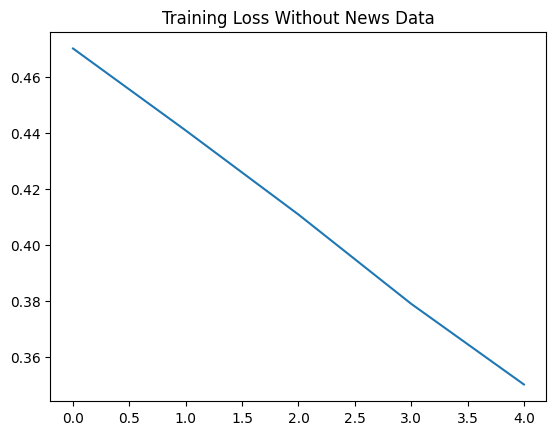

In [14]:
plt.figure()
plt.plot( history.history[ "loss"], label="Loss")
plt.title( "Training Loss Without News Data")
plt.show()

##### denormalize data

In [15]:
def denormalize( data, record_min, record_max):
    denormalized = []
    for i in range( len( data)):
        minimum = record_min[ i]
        maximum = record_max[ i]
        diff = maximum - minimum
        denormalized.append( data[ i] * diff + minimum)

    return np.array( denormalized)

##### predict all data

In [16]:
all_data_windows = create_win_data( adj_close, SEQUENCE_LENGTH)
normalized_all_data, record_min_all, record_max_all = normalize( all_data_windows)
x_all, y_all = input_labels( normalized_all_data)

In [17]:
y_all_pred = model.predict( x_all)

4/4 [==============================] - 2s 7ms/step


In [18]:
y_all_pred_denormalize = denormalize( y_all_pred, record_min_all, record_max_all)

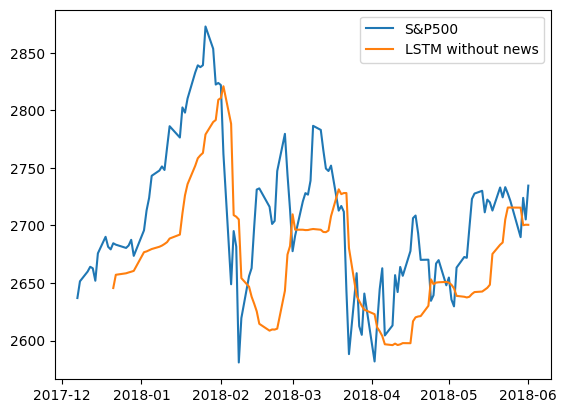

In [19]:
x = [ datetime.strptime( d, "%Y-%m-%d") for d in df[ "date"].values]

plt.figure()
plt.plot( x, adj_close, label="S&P500")
plt.plot( x[ 10:], y_all_pred_denormalize, label="LSTM without news")
plt.legend()
plt.show()

##### predict test data

In [20]:
prediction_sequence = []
prediction_window_numbers = int( len( x_test) / PREDICTION_LENGTH)

for i in range( prediction_window_numbers):
    current_frame = x_test[ i * PREDICTION_LENGTH]
    predicted = []
    for j in range( PREDICTION_LENGTH):
        t = model.predict( current_frame[ np.newaxis, :])[ 0]
        predicted.append( t)
        current_frame = current_frame[ 1:]
        current_frame = np.insert( current_frame, [ SEQUENCE_LENGTH - 2], predicted[ -1], axis=0)
    prediction_sequence.append( predicted)

prediction_sequence = np.array( prediction_sequence)

1/1 [==============================] - 0s 25ms/step


##### test label original (denormalized)

In [21]:
y_test_orig = denormalize( y_test, record_min_test, record_max_test)

##### denormalize predicted labels

In [22]:
y_pred_denormalized = denormalize( prediction_sequence.flatten(), record_min_test, record_max_test)

##### evaluation

In [23]:
error = []
squared_error = []
abs_error = []
error_percent = []

for i in range( len( y_test_orig)):
    e = y_test_orig[ i] - y_pred_denormalized[ i]
    error.append( e)
    squared_error.append( e ** 2)
    abs_error.append( np.abs( e))
    error_percent.append( np.abs( e) / y_test_orig[ i])

mean_percent_error = np.sum( error_percent) / len( error_percent)
accuracy = 1 - mean_percent_error

MSE = np.sum( squared_error) / len( squared_error)

print( f"MSE: { MSE}")
print( f"Accuracy: { accuracy}")
print( f"Mean Error Percent: { mean_percent_error}")

MSE: 523.195615522655
Accuracy: 0.9930263834635706
Mean Error Percent: 0.006973616536429329
